## How To Backtest Machine Learning Models for Time Series Forecasting
### Adapted from:
- https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

## Model Evaluation
- The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem.
- Evaluation of machine learning models on time series data is called backtesting or hindcasting.
- When evaluating a model for time series forecasting, we are interested in the performance of the model on data that was not used to train it. In machine learning, we call this unseen or out of sample data.
- In applied machine learning, we often split our data into a train and a test set: the training set used to prepare the model and the test set used to evaluate it. We may even use k-fold cross validation that repeats this process by systematically splitting the data into k groups, each given a chance to be a held out model.
    - **These methods cannot be directly used with time series data.**
- This is because they assume that there is no relationship between the observations, i.e. that each observation is independent from the other observations.
- In the case of time series this is not true, where the time dimension of observations means that we cannot randomly split them into groups. **Instead, we must split data up and respect the temporal order in which values were observed.**
- In time series forecasting, this evaluation of models on historical data is called backtesting. In some time series domains, such as meteorology, this is called hindcasting, as opposed to forecasting.
- We will look at three different methods that you can use to backtest your machine learning models on time series problems. They are:
    - **Train-Test split** that respect temporal order of observations.
    - **Multiple Train-Test splits** that respect temporal order of observations.
    - **Walk-Forward Validation** where a model may be updated each time step new data is received.

In [19]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection as sklModelSel

%matplotlib inline

Month
1749-01    58.0
1749-02    62.6
1749-03    70.0
1749-04    55.7
1749-05    85.0
Name: Zuerich monthly sunspot numbers 1749-1983, dtype: float64


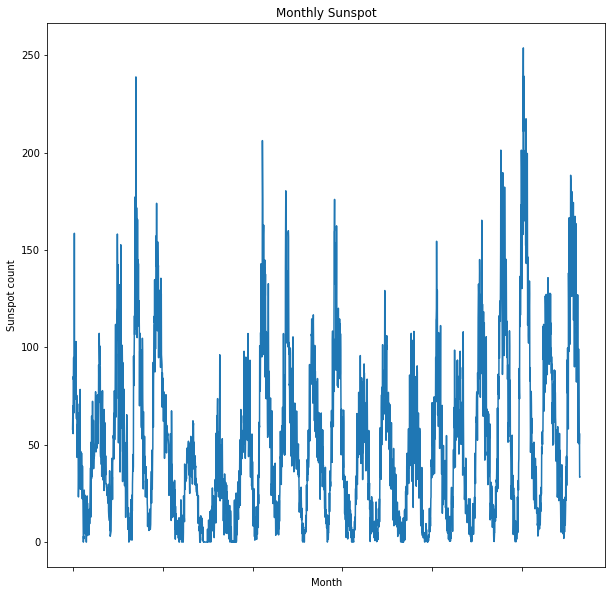

In [20]:
# Load sunspot data
series = pd.Series.from_csv('sunspots.csv', header=0)

print(series.head())

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Monthly Sunspot')
ax.set_ylabel('Sunspot count')
ax.set_xlabel('Month')

series.plot()
plt.show()

## Train-Test Split
- You can split your dataset into training and testing subsets. Your model can be prepared on the training dataset and predictions can be made and evaluated for the test dataset.
- This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets. Depending on the amount of data you have available and the amount of data required, you can use splits of 50-50, 70-30 and 90-10.
- Below is an example of this in Python using a split of 66-34.
- Using a train-test split method to evaluate machine learning models is fast. Preparing the data is simple and intuitive and only one model is created and evaluated.
- It is useful when you have a large amount of data so that both training and tests sets are representative of the original problem.

Observations: 2821
Training Observations: 1861
Testing Observations: 960


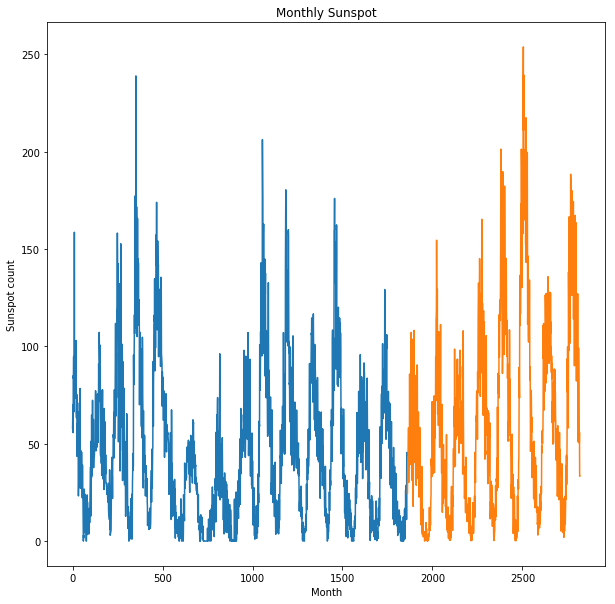

In [21]:
X = series.values

train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)
ax = fig.add_subplot(1, 1, 1)

ax.set_title('Monthly Sunspot')
ax.set_ylabel('Sunspot count')
ax.set_xlabel('Month')

plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.show()

## Multiple Train-Test Splits
- We can repeat the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data.
- We could do this manually by repeating the process described in the previous section with different split points. Alternately, the scikit-learn library provides this capability for us in the TimeSeriesSplit object.
- You must specify the number of splits to create and the TimeSeriesSplit to return the indexes of the train and test observations for each requested split.
- The total number of training and test observations are calculated each split iteration (i) as follows:
    - n_samples --> Total number of observations
    - n_splits --> Total number of splits
    
    `training_size = i * n_samples / (n_splits + 1) + n_samples % (n_splits + 1)
    test_size = n_samples / (n_splits + 1)`
- Below you can see that the test size stays consistent. **This means that performance statistics calculated on the predictions of each trained model will be consistent and can be combined and compared.** It provides an apples-to-apples comparison.
- What differs is the number of records used to train the model for each split, offering a larger and larger history to work with.
- This may make an interesting aspect of the analysis of results. Alternately, this too could be controlled by holding the number of observations used to train the model consistent and only using the same number of the most recent (last) observations in the training dataset each split to train the model.
- Below we are using the scikit-learn TimeSeriesSplit on the sunspot data.
- The dataset has 2,820 observations. Let’s create 3 splits for the dataset. Using the same arithmetic above, we would expect the following train and test splits to be created:
    - **Split 1:** 705 train, 705 test
    - **Split 2:** 1,410 train, 705 test
    - **Split 3:** 2,115 train, 705 test
- Using multiple train-test splits will result in more models being trained, and in turn, a more accurate estimate of the performance of the models on unseen data.
- A limitation of the train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set.
- This may not be realistic as models can be retrained as new daily or monthly observations are made available. This concern is addressed by the 'Walk Forward Validation'.

Observations: 1411
Training Observations: 706
Testing Observations: 705

Observations: 2116
Training Observations: 1411
Testing Observations: 705

Observations: 2821
Training Observations: 2116
Testing Observations: 705



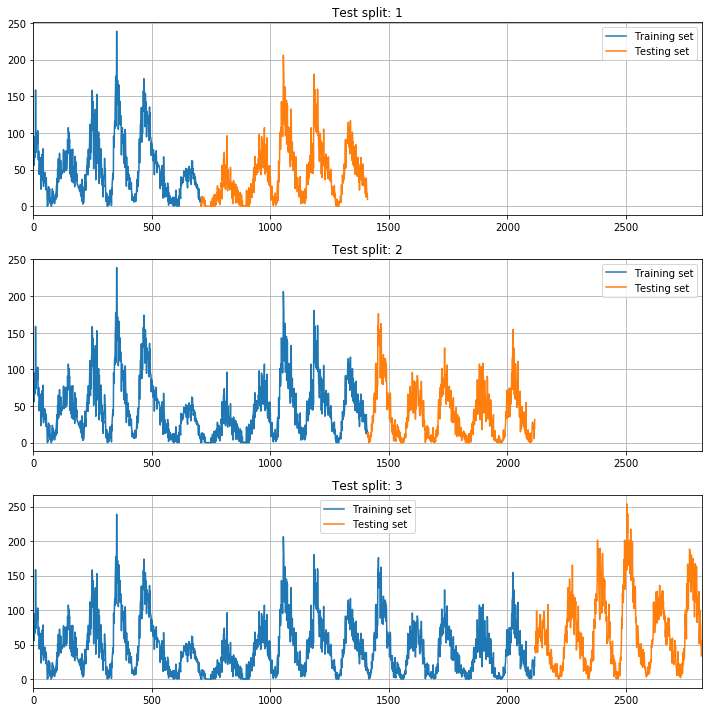

In [53]:
splitCount = 3

X = series.values
splits = sklModelSel.TimeSeriesSplit(n_splits=splitCount)

fig = plt.figure()
fig.set_figwidth(10)
fig.set_figheight(10)

index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d\n' % (len(test)))
    
    title = 'Test split: ' + str(index)
    ax = fig.add_subplot(splitCount, 1, index)
    ax.grid()
    ax.set_title(title)
    ax.set_xlim(right=len(series))
    ax.plot(train)
    ax.plot([None for i in train] + [x for x in test])
    ax.legend(['Training set', 'Testing set'])
    
    index += 1

fig.tight_layout()
plt.show()

## Walk Forward Validation
- In practice, we very likely will retrain our model as new data becomes available, rather than re-training the model from scratch. This would give the model the best opportunity to make good forecasts at each time step. We can evaluate our machine learning models under this assumption.
- There are few decisions to make:
    1. **Minimum Number of Observations:** First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).
    2. **Sliding or Expanding Window:** Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.
- After a sensible configuration is chosen for your test-setup, models can be trained and evaluated:
    1. Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model.
    2. The model makes a prediction for the next time step.
    3. The prediction is stored or evaluated against the known value.
    4. The window is expanded to include the known value and the process is repeated (go to step 1.)
- Because this methodology involves moving along the time series one-time step at a time, it is often called **Walk Forward Testing** or **Walk Forward Validation**.
- Additionally, because a sliding or expanding window is used to train a model, this method is also referred to as **Rolling Window Analysis** or a **Rolling Forecast**.
- This capability is currently not available in scikit-learn, although you could contrive the same effect with a carefully configured TimeSeriesSplit.
- Below is an example of how to split data into train and test sets using the Walk Forward Validation method.
- Running the example simply prints the size of the training and test sets created. We can see the training set is expanding with each time step and the test set is fixed at one time step ahead.
- Within the loop is where you would train and evaluate your model. You can see that many more models are created.
- This has the benefit again of providing a much more robust estimation of how the chosen modeling method and parameters will perform in practice. **This improved estimate comes at the computational cost of creating so many models**. **This is not expensive if the modeling method is simple or dataset is small (as in this example), but could be an issue at scale**. In the above case, 2,820 models would be created and evaluated.
- As such, careful attention needs to be paid to the window width and window type. These could be adjusted to contrive a test harness on your problem that is significantly less computationally expensive.
- Walk-forward validation is the gold standard of model evaluation. It is the k-fold cross validation of the time series world and is recommended for your own projects.

In [54]:
X = series.values

n_train = 500
n_records = len(X)

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))

train=500, test=1
train=501, test=1
train=502, test=1
train=503, test=1
train=504, test=1
train=505, test=1
train=506, test=1
train=507, test=1
train=508, test=1
train=509, test=1
train=510, test=1
train=511, test=1
train=512, test=1
train=513, test=1
train=514, test=1
train=515, test=1
train=516, test=1
train=517, test=1
train=518, test=1
train=519, test=1
train=520, test=1
train=521, test=1
train=522, test=1
train=523, test=1
train=524, test=1
train=525, test=1
train=526, test=1
train=527, test=1
train=528, test=1
train=529, test=1
train=530, test=1
train=531, test=1
train=532, test=1
train=533, test=1
train=534, test=1
train=535, test=1
train=536, test=1
train=537, test=1
train=538, test=1
train=539, test=1
train=540, test=1
train=541, test=1
train=542, test=1
train=543, test=1
train=544, test=1
train=545, test=1
train=546, test=1
train=547, test=1
train=548, test=1
train=549, test=1
train=550, test=1
train=551, test=1
train=552, test=1
train=553, test=1
train=554, test=1
train=555,

train=2753, test=1
train=2754, test=1
train=2755, test=1
train=2756, test=1
train=2757, test=1
train=2758, test=1
train=2759, test=1
train=2760, test=1
train=2761, test=1
train=2762, test=1
train=2763, test=1
train=2764, test=1
train=2765, test=1
train=2766, test=1
train=2767, test=1
train=2768, test=1
train=2769, test=1
train=2770, test=1
train=2771, test=1
train=2772, test=1
train=2773, test=1
train=2774, test=1
train=2775, test=1
train=2776, test=1
train=2777, test=1
train=2778, test=1
train=2779, test=1
train=2780, test=1
train=2781, test=1
train=2782, test=1
train=2783, test=1
train=2784, test=1
train=2785, test=1
train=2786, test=1
train=2787, test=1
train=2788, test=1
train=2789, test=1
train=2790, test=1
train=2791, test=1
train=2792, test=1
train=2793, test=1
train=2794, test=1
train=2795, test=1
train=2796, test=1
train=2797, test=1
train=2798, test=1
train=2799, test=1
train=2800, test=1
train=2801, test=1
train=2802, test=1
train=2803, test=1
train=2804, test=1
train=2805, 